# Laboratorium 9

### 0. Wczytanie danych
Używając metody `load_svmlight_file` z modułu `sklearn` załaduj plik `lab13_files/breast_cancer`, który składa się z 2 elementów: macierzy `X` o wymiarach `683 x 10` oraz wektora `y` o dlugosci `683`. Macierz `X` opisuje badania 683 pacjentow, a wektor `y` ich diagnozy. 

In [2]:
from sklearn.datasets import load_svmlight_file

X, y = load_svmlight_file('lab13_files/breast-cancer')
X = X.toarray()

### 1. Preprocessing
1.1 Korzystajac z `numpy.where` przenumeruj wektor y, tzn zamień wartości 2 i 4 na -1 i +1. 

1.2 Przeskaluj macierz X, tak żeby wartości w każdej kolumnie mieściły się w zakresie [0,1], innymi słowy przeskaluj niezależnie każdą kolumne $X_j$ wg wzoru:


$$
X_j = \frac{X_j-\min(X_j)}{\max(X_j)-\min(X_j)}
$$

In [3]:
import numpy as np
np.set_printoptions(precision=1)

y = np.where(y == 4, 1, -1)
min_vals = X.min(axis=0) 
max_vals = X.max(axis=0) 

X = (X - min_vals) / (max_vals - min_vals)


### 2. Wizualizacja
Narysuj dane używajac biblioteki `matplotlib`. Użyj wymiarów 1 i 2 z macierzy X, a jako kolory użyj wektora y. Pobaw sie parametrami "s" oraz "alpha" metody `plt.scatter` żeby uzyskać czytelną wizualizacje, np. taką jak poniżej.

<img src="lab13_files/d.png">

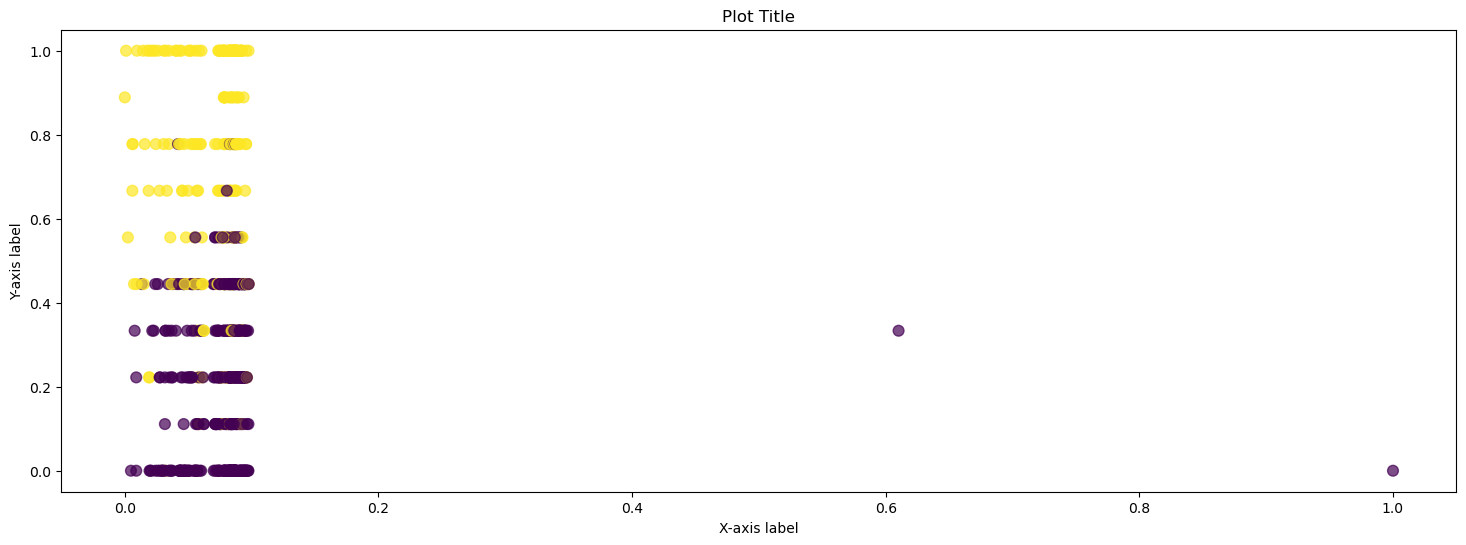

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))

plt.scatter(X[:,0], X[:,1], c=y , s = 60, alpha=0.7)

plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Plot Title')
plt.show()

### 3. Regresja 

Przeprowadź regresje liniową wg wzoru:
$$
\beta = (X^TX)^{-1}X^Ty
$$

In [5]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y

### 4. Wizualizacja Regresji

Zwizualizuj dane po zrzutowaniu na $\beta$ używajac metody `plt.hist`, tzn. narysuj histogramy $\beta X_+$ oraz
$\beta X_-$ gdzie $X_+$ to wiersze $X$ dla których $y=+1$ i analogicznie $X_-$. Postaraj się wygenerować czytelny wykres podobny do tego poniżej.

<img src="lab13_files/lr1.png">

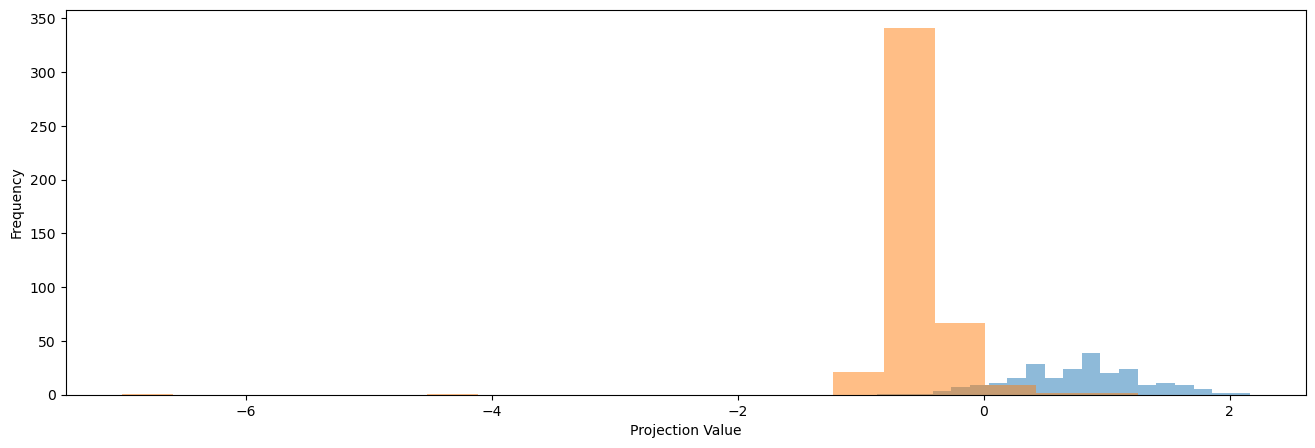

In [6]:
X_plus = X[y == 1]
X_minus = X[y == -1]
projection_plus = np.dot(X_plus, beta)
projection_minus = np.dot(X_minus, beta)
plt.figure(figsize=(16,5))
plt.hist(projection_plus, bins=20 ,alpha=0.5, label='Projection for y=+1')
plt.hist(projection_minus, bins=20, alpha=0.5, label='Projection for y=-1')

plt.xlabel('Projection Value')
plt.ylabel('Frequency')
plt.show()

### 5. Klasyfikacja

Przeprowadź "klasyfikacje" naszych pacjentów, ci, którzy zostali zrzutowani na wartość ujemną dostają etykiete $-1$, a ci którzy na wartość dodatnia - etykiete $+1$

In [7]:
labels = np.where(y >= 0, 1, -1)


### 6. Ewaluacja

Policz jak dokładny jest ten model, tzn. jak duży jest zbiór
$ \{ (x_i,y_i) : \mathrm{sign}(\beta x_i) = y_i \} $
w stosunku do rozmiaru całego $y$

Powinno udać się uzyskać wynik na poziomie 93-94%

In [8]:
import numpy as np


predictions = np.sign(np.dot(X, beta))

accuracy = np.mean(predictions == y)

print("Dokładność modelu:", accuracy)


Dokładność modelu: 0.9487554904831625


### 7. Regularyzacja 
Dodaj parametr `C` do regresji liniowej
$$
\beta = (X^TX + \tfrac{1}{C}I)^{-1}X^Ty
$$

gdzie $I$ - macierz identyczności. 

Dla jakiej wartości `C` wynik jest najlepszy? Jaki wynik udało Ci sie uzyskać?

In [9]:
from sklearn.linear_model import RidgeCV
C = 1

I = np.identity(X.shape[1]) 
beta = np.linalg.inv(X.T @ X + (1 / C) * I) @ X.T @ y
predictions = np.sign(np.dot(X, beta))
accuracy = np.mean(predictions == y)
print("Dokładność modelu:", accuracy) # dla c =1

Dokładność modelu: 0.9502196193265008


### 8. Gratulacje
Właśnie stworzyłeś/-aś swój pierwszy klasyfikator (statystyczny model predykcji). 

Spróbuj zastosować go do innych danych.

### Zadanie dodatkowe

Zaimplementuj powyższą metode jako klase `LRClassifier` wyposażoną w następujące metody:

* konstruktor przyjmujący dwa parametry: 
    * `C` - stała z równania 
    * `scale` - zmienna boolowska (domyslnie `True`) która określa czy macierz `X` ma byc automatycznie znormalizowana (przeskalowana do `[0,1]`)
* `.fit(X, y)` która spowoduje obliczenie $\beta$, dla `X` - dowolnej macierzy, `y` - wektora etykiet skladajacego sie z dwóch unikalnych wartosci (mogą to byc np. 2 różne stringi)
* `.predict(X)`, która zwróci wektor zawierajacy na `i`tej pozycji etykiete "przewidzianą" przez nasz model (pamiętaj o skalowaniu jesli `scale==True`!)

Przykladowe użycie:

    clf = LRClassifier(C=100)
    Xt = np.array([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4]])
    yt = np.array(['x', 'x', 'y', 'y', 'y'])
    clf.fit(Xt, yt)
    X = np.array([[1, -1], [1, 0.9], [1, 2.1]])
    print(clf.predict(X)) # ['x', 'x', 'y']

In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

class LRClassifier:
    def __init__(self, C=1.0, scale=True):
        self.C = C
        self.scale = scale
        self.beta = None
        self.scaler = None
    
    def _add_intercept(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))
    
    def _scale_features(self, X):
        self.scaler = MinMaxScaler()
        X_scaled = self.scaler.fit_transform(X[:, 1:])  # Pomijamy pierwszą kolumnę z jedynkami
        return np.hstack((np.ones((X.shape[0], 1)), X_scaled))
    
    def fit(self, X, y):
        if self.scale:
            X = self._scale_features(X)
        else:
            X = self._add_intercept(X)
        
        unique_labels = np.unique(y)

        label_map = {unique_labels[0]: -1, unique_labels[1]: 1}
        y_binary = np.array([label_map[label] for label in y])
        
        I = np.identity(X.shape[1]) 
        self.beta = np.linalg.inv( X.T @ X + (1 / self.C) * I) @ X.T @ y_binary
    
    def predict(self, X):
        if self.scale:
            X = self._scale_features(X)
        else:
            X = self._add_intercept(X)
        
        predictions = np.sign(X @ self.beta)
        
        unique_labels = np.unique(y)
        label_map = {-1: unique_labels[0], 1: unique_labels[1]}
        return np.array([label_map[label] for label in predictions])

# Przykładowe użycie
clf = LRClassifier(C=100)
Xt = np.array([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4]])
yt = np.array(['x', 'x', 'y', 'y', 'y'])
clf.fit(Xt, yt)
X = np.array([[1, -1], [1, 0.9], [1, 2.1]])
print(clf.predict(X))  # ['x', 'x', 'y']


[-1  1  1]
